In [295]:
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from tensorflow import keras
import numpy as np
import os
from keras.src.layers import Rescaling

warnings.filterwarnings('ignore')

Sequential = keras.models.Sequential
Conv2D = keras.layers.Conv2D
Flatten = keras.layers.Flatten
Dropout = keras.layers.Dropout
MaxPooling2D = keras.layers.MaxPooling2D
Dense = keras.layers.Dense
Input = keras.layers.Input
EarlyStopping = keras.callbacks.EarlyStopping
ReduceLROnPlateau = keras.callbacks.ReduceLROnPlateau
Layers = keras.layers
ImageDataGenerator = keras.preprocessing.image.ImageDataGenerator
BatchNormalization = keras.layers.BatchNormalization

In [296]:
train_path = 'data/training/train'
test_path = 'data/testing/test'
pred_path = 'data/prediction'

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30

In [297]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_datagen = ImageDataGenerator()

In [298]:
train_ds = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 14034 images belonging to 6 classes.


In [299]:
class_names = list(train_ds.class_indices.keys())
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [300]:
test_ds = test_datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 3000 images belonging to 6 classes.


In [301]:
class_names = list(test_ds.class_indices.keys())
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [302]:
def image_path(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names


images_paths = image_path(pred_path)
len(images_paths)

7301

In [303]:
images_paths = image_path(train_path)
len(images_paths)

14034

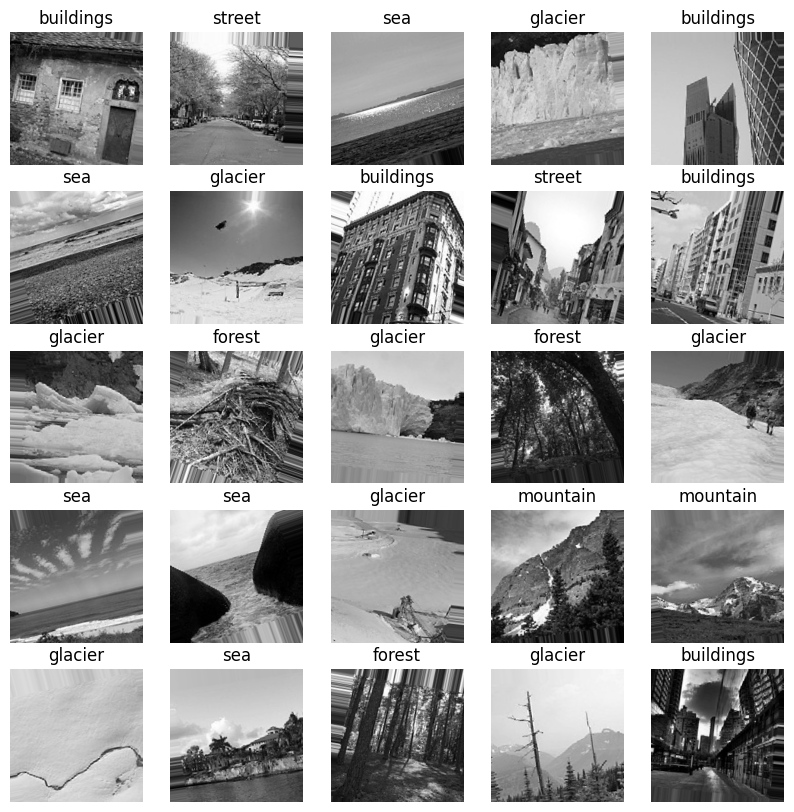

In [304]:
images, labels = next(train_ds)

plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].astype("uint8"), cmap="gray")
    class_index = np.argmax(labels[i])
    plt.title(class_names[class_index])
    plt.axis('off')

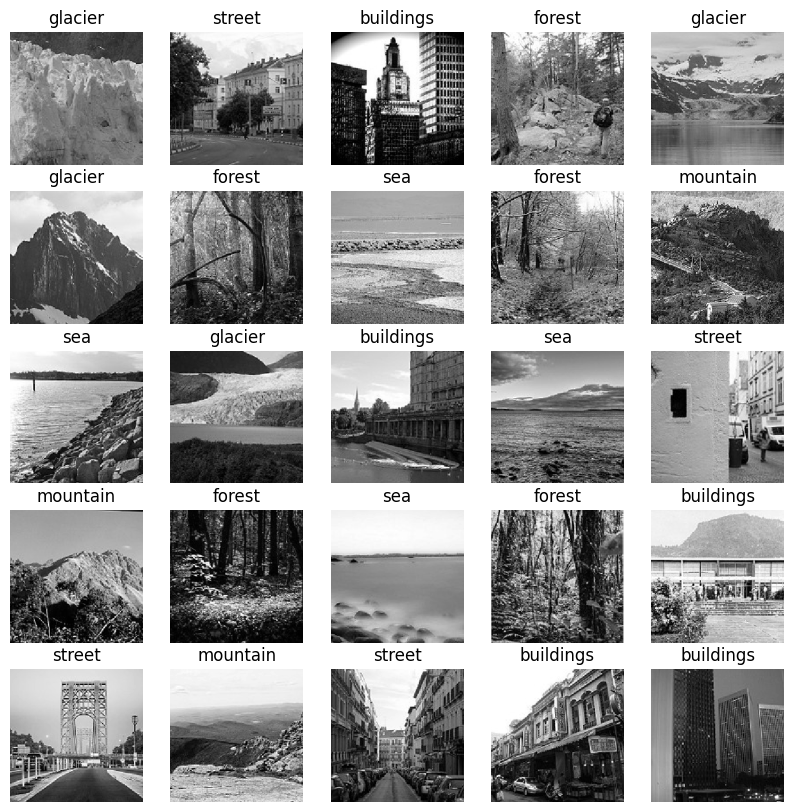

In [305]:
images, labels = next(test_ds)

plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].astype("uint8"), cmap="gray")
    class_index = np.argmax(labels[i])
    plt.title(class_names[class_index])
    plt.axis('off')

In [306]:
class_counts = {}
for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        class_counts[class_name] = num_images
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

forest: 2271 images
buildings: 2191 images
glacier: 2404 images
street: 2382 images
mountain: 2512 images
sea: 2274 images


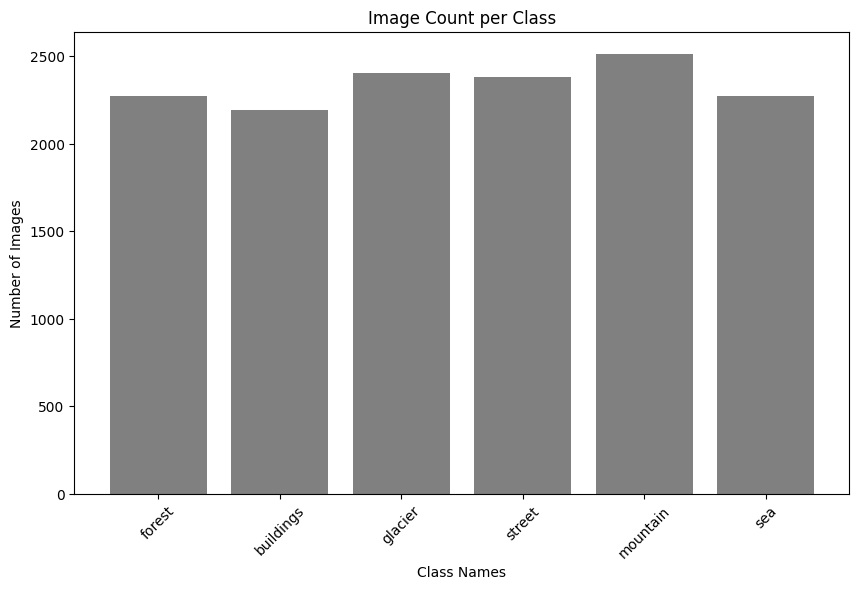

In [307]:
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='gray')
plt.title('Image Count per Class')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [308]:
class_counts = {}
for class_name in os.listdir(test_path):
    class_dir = os.path.join(test_path, class_name)
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        class_counts[class_name] = num_images
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

forest: 474 images
buildings: 437 images
glacier: 553 images
street: 501 images
mountain: 525 images
sea: 510 images


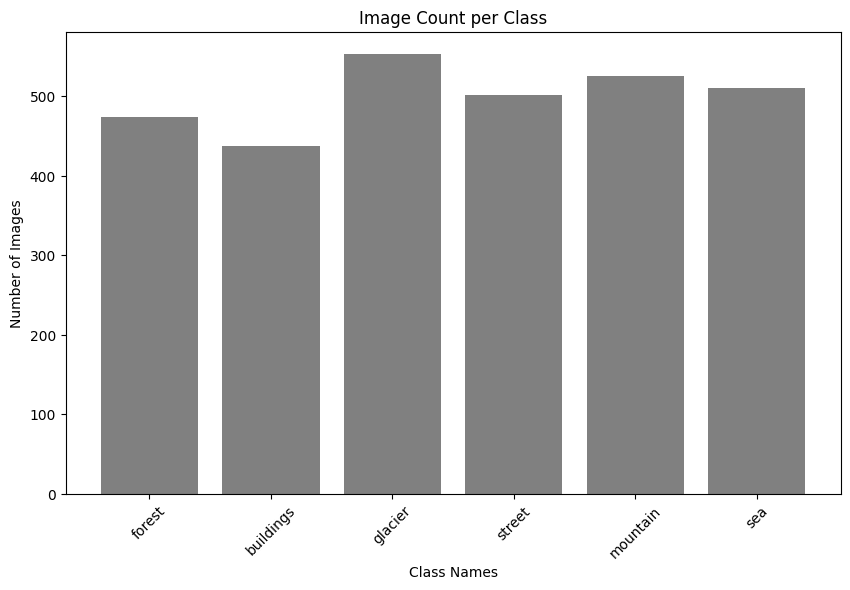

In [309]:
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='gray')
plt.title('Image Count per Class')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [310]:
# Define the model architecture
model = Sequential()

# Normalization
model.add(Rescaling(1. / 255, input_shape=(224, 224, 1)))

# Convolutional layers 
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Flatten and dense layers with Dropout
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(units=len(class_names), activation='softmax'))

In [311]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_11 (Rescaling)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 220, 220, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 220, 220, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 106, 106, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 106, 106, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 51, 51, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 23, 23, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 23, 23, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │    15,860,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,349,702 (62.37 MB)

 Trainable params: 16,348,742 (62.37 MB)

 Non-trainable params: 960 (3.75 KB)

In [314]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Learning Rate Reduction
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    min_delta=0.001,
    mode='min'
)

# Train model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr]
)

# Save model
model.save('output/model/cnn_model_v1.h5')

Epoch 1/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 660s 1s/step - accuracy: 0.2897 - loss: 4.4907 - val_accuracy: 0.4093 - val_loss: 1.4442 - learning_rate: 0.0010
Epoch 2/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 646s 1s/step - accuracy: 0.3903 - loss: 1.4338 - val_accuracy: 0.4237 - val_loss: 1.3087 - learning_rate: 0.0010
Epoch 3/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 628s 1s/step - accuracy: 0.4195 - loss: 1.3581 - val_accuracy: 0.2253 - val_loss: 1.5126 - learning_rate: 0.0010
Epoch 4/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 626s 1s/step - accuracy: 0.4831 - loss: 1.2545 - val_accuracy: 0.1883 - val_loss: 3.6250 - learning_rate: 0.0010
Epoch 5/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 645s 1s/step - accuracy: 0.5227 - loss: 1.1346 - val_accuracy: 0.6010 - val_loss: 1.0106 - learning_rate: 5.0000e-04
Epoch 6/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 671s 2s/step - accuracy: 0.5566 - loss: 1.0592 - val_accuracy: 0.5193 - val_loss: 1.0571 - learning_rate: 5.0000e-04
Epoch 7/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 698s 2s/step - accuracy: 0.5992 - 

In [315]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 320ms/step - accuracy: 0.8308 - loss: 0.4926
Test accuracy: 82.87%


In [316]:
# Evaluate the model on the training dataset
train_loss, train_accuracy = model.evaluate(train_ds)
print(f'Train accuracy: {train_accuracy * 100:.2f}%')

439/439 ━━━━━━━━━━━━━━━━━━━━ 138s 315ms/step - accuracy: 0.8175 - loss: 0.4939
Train accuracy: 82.51%


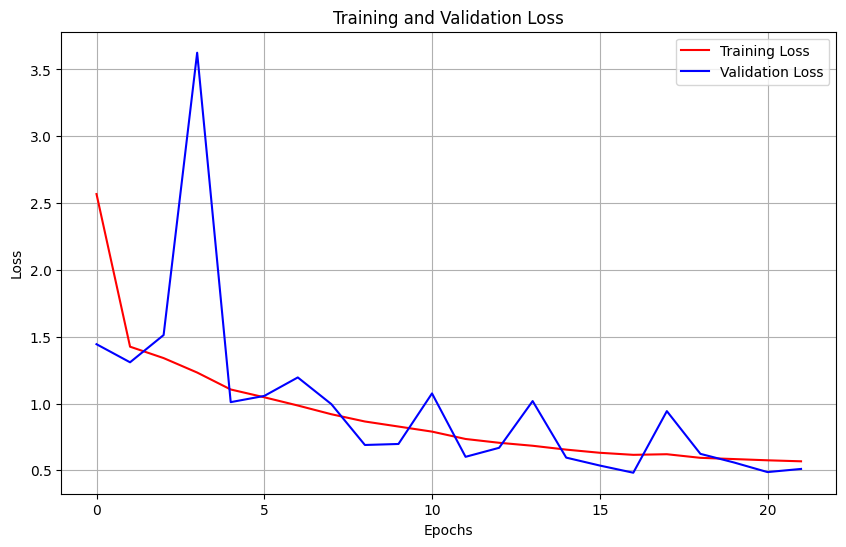

In [320]:
# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, color="red", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig("output/plot/training_validation_loss_v1.png", format="png", dpi=300)

# Display the plot
plt.show()

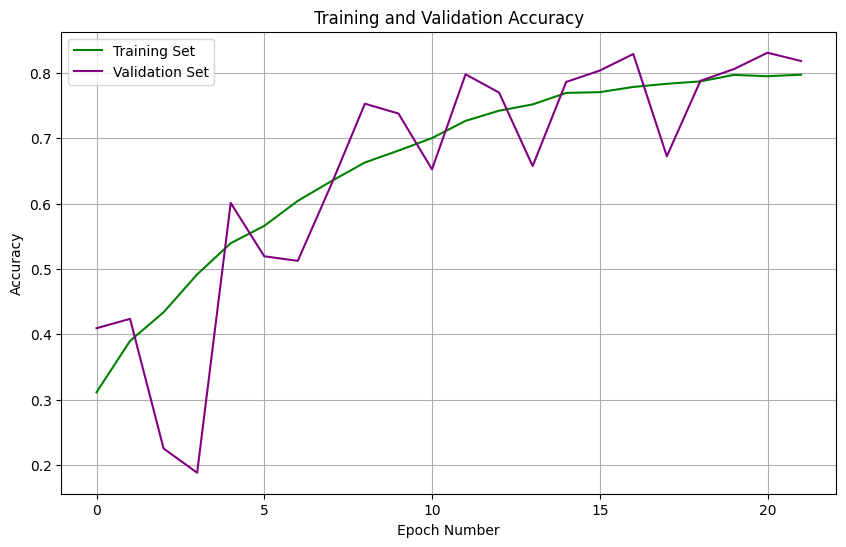

In [321]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label="Training Set", color="green")
plt.plot(history.history['val_accuracy'], label="Validation Set", color="purple")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig("output/plot/training_validation_accuracy_v1.png", format="png", dpi=300)

# Display the plot
plt.show()